<a href="https://colab.research.google.com/github/akhraishasnaeencg-design/The-Enron-Email-Dataset/blob/main/The_Enron_Email_Dataset_dbscan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


ENRON EMAIL ANALYSIS - DBSCAN FINAL
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset chargé ✅
Taille totale : 517401
Taille échantillon : 50000
Emails suspects simulés : 17813
Vectorisation TF-IDF...
Graphique K-distance...


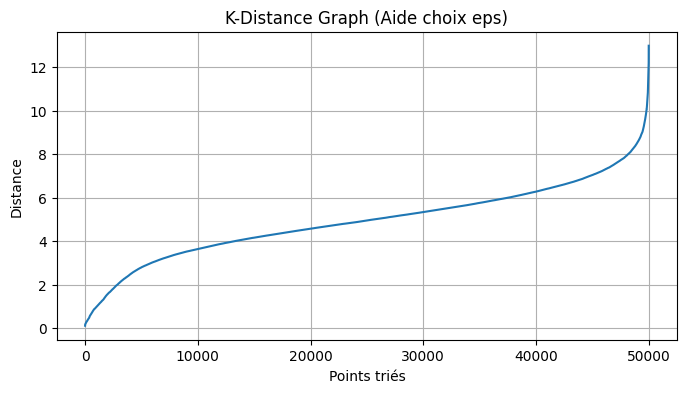

Recherche automatique du meilleur eps...
Meilleur eps : 1.1000000000000003
Silhouette Score : -0.2925
Nombre de clusters : 47
Taux d'anomalies : 97.0 %
Projection PCA...


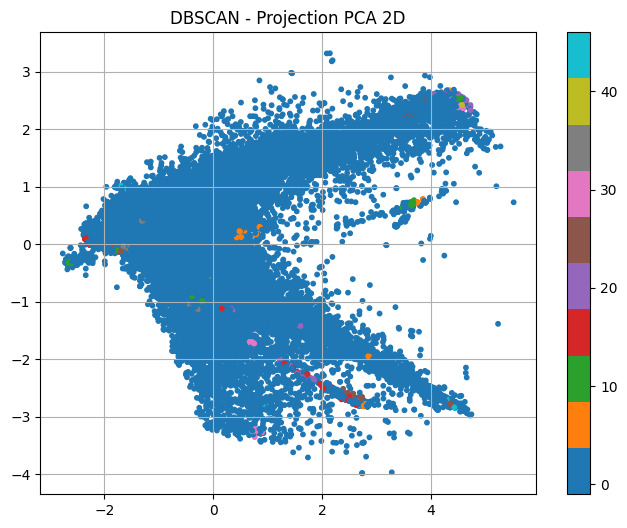

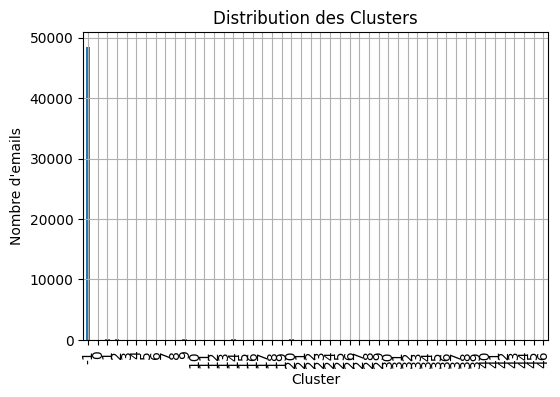

Matrice de confusion...


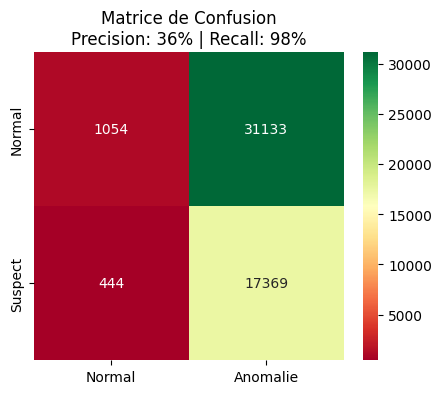


================ RESULTATS ================
Total emails : 50000
Emails suspects simulés : 17813
Emails détectés anomalies : 48502
Precision : 35.81%
Recall : 97.51%
Silhouette Score : -0.2925


In [4]:
# =====================================================
# INSTALLATION DES BIBLIOTHEQUES
# =====================================================
!pip install pandas numpy scikit-learn matplotlib seaborn

# =====================================================
# IMPORTS
# =====================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix, silhouette_score

print("\n======================================")
print("ENRON EMAIL ANALYSIS - DBSCAN FINAL")
print("======================================")

# =====================================================
# MONTER GOOGLE DRIVE
# =====================================================
drive.mount('/content/drive')

# =====================================================
# CHARGER LE CSV DEPUIS DRIVE
# =====================================================
csv_path = "/content/drive/MyDrive/emails.csv.zip"
df = pd.read_csv(csv_path)

print("Dataset chargé ✅")
print("Taille totale :", len(df))

# =====================================================
# PREPARATION DES DONNEES
# =====================================================
df = df.dropna(subset=["message"])
df_sample = df.sample(n=50000, random_state=42)

print("Taille échantillon :", len(df_sample))

# =====================================================
# CREATION LABEL PEDAGOGIQUE (SIMULATION SPAM)
# =====================================================
keywords = ["free", "money", "offer", "win", "cash", "urgent"]

def label_email(text):
    text = text.lower()
    return 1 if any(word in text for word in keywords) else 0

df_sample["Vrai_Label"] = df_sample["message"].apply(label_email)

print("Emails suspects simulés :", df_sample["Vrai_Label"].sum())

# =====================================================
# TF-IDF
# =====================================================
print("Vectorisation TF-IDF...")

vectorizer = TfidfVectorizer(stop_words="english", max_features=3000)
X = vectorizer.fit_transform(df_sample["message"])

# =====================================================
# REDUCTION DIMENSION (SVD)
# =====================================================
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X)

# =====================================================
# STANDARDISATION
# =====================================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

# =====================================================
# GRAPHIQUE K-DISTANCE
# =====================================================
print("Graphique K-distance...")

neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X_scaled)

distances, _ = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, 9])

plt.figure(figsize=(8,4))
plt.plot(distances)
plt.title("K-Distance Graph (Aide choix eps)")
plt.xlabel("Points triés")
plt.ylabel("Distance")
plt.grid(True)
plt.show()

# =====================================================
# OPTIMISATION AUTOMATIQUE EPS
# =====================================================
print("Recherche automatique du meilleur eps...")

eps_values = np.arange(0.3, 1.5, 0.1)
best_score = -1
best_eps = None
best_labels = None

for eps in eps_values:
    model = DBSCAN(eps=eps, min_samples=10)
    labels = model.fit_predict(X_scaled)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    if n_clusters > 1:
        score = silhouette_score(X_scaled, labels, sample_size=5000, random_state=42)

        if score > best_score:
            best_score = score
            best_eps = eps
            best_labels = labels

print("Meilleur eps :", best_eps)
print("Silhouette Score :", round(best_score,4))

# =====================================================
# MODELE FINAL
# =====================================================
labels = best_labels
df_sample["Cluster"] = labels
df_sample["Anomalie"] = labels == -1

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
anomaly_rate = df_sample["Anomalie"].mean()

print("Nombre de clusters :", n_clusters)
print("Taux d'anomalies :", round(anomaly_rate*100,2), "%")

# =====================================================
# VISUALISATION PCA
# =====================================================
print("Projection PCA...")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap="tab10", s=10)
plt.title("DBSCAN - Projection PCA 2D")
plt.colorbar(scatter)
plt.grid(True)
plt.show()

# =====================================================
# DISTRIBUTION DES CLUSTERS
# =====================================================
plt.figure(figsize=(6,4))
df_sample["Cluster"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribution des Clusters")
plt.xlabel("Cluster")
plt.ylabel("Nombre d'emails")
plt.grid(True)
plt.show()

# =====================================================
# MATRICE DE CONFUSION
# =====================================================
print("Matrice de confusion...")

y_true = df_sample["Vrai_Label"]
y_pred = df_sample["Anomalie"].astype(int)

cm = confusion_matrix(y_true, y_pred)

tp = cm[1,1]
fp = cm[0,1]
tn = cm[0,0]
fn = cm[1,0]

precision = tp/(tp+fp) if (tp+fp)>0 else 0
recall = tp/(tp+fn) if (tp+fn)>0 else 0

plt.figure(figsize=(5,4))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="RdYlGn",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Suspect"])

plt.title(f"Matrice de Confusion\nPrecision: {precision:.0%} | Recall: {recall:.0%}")
plt.show()

# =====================================================
# RESULTATS FINAUX
# =====================================================
print("\n================ RESULTATS ================")
print("Total emails :", len(df_sample))
print("Emails suspects simulés :", y_true.sum())
print("Emails détectés anomalies :", df_sample["Anomalie"].sum())
print("Precision :", f"{precision:.2%}")
print("Recall :", f"{recall:.2%}")
print("Silhouette Score :", round(best_score,4))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
